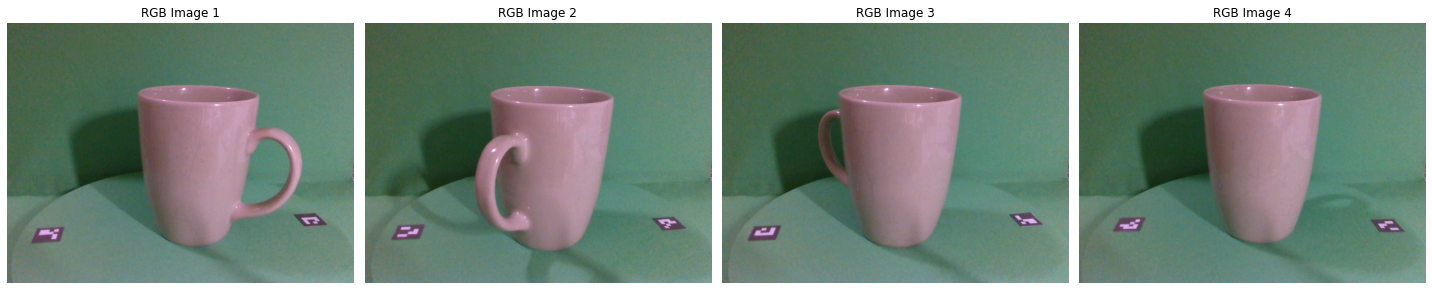

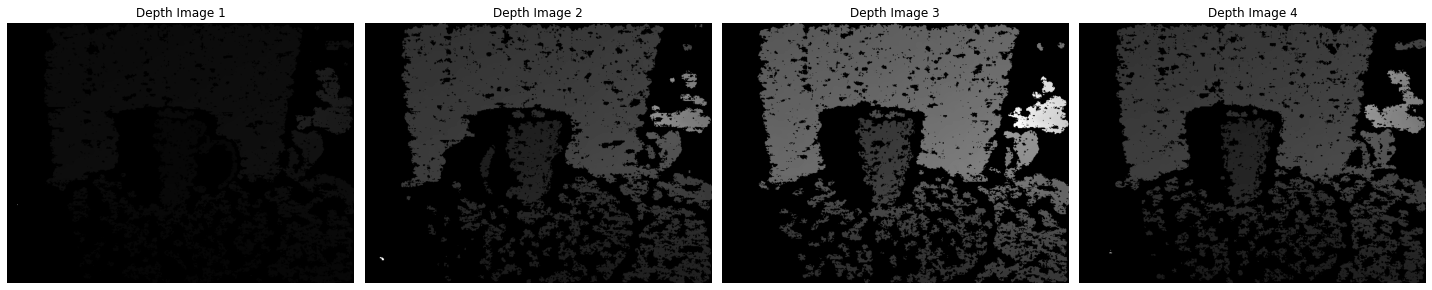

In [3]:
'''
This module handles the creation of the mesh object (.obj)

'''

import numpy as np
import cv2
import matplotlib.pyplot as plt

path_to_images = "../test_images/"

# Load RGB and depth images into lists for later use
rgb_images = []
depth_images = []

for i in range(5,9):
    # Load and store RGB image
    img_rgb = cv2.imread(path_to_images + "rgb_image_" + f"{i}.png")
    if img_rgb is not None:
        img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
        rgb_images.append(img_rgb)
    else:
        print(f"RGB Image {i} not found")
    
    # Load and store depth image
    img_depth = cv2.imread(path_to_images + "depth_image_" + f"{i}.png", cv2.IMREAD_UNCHANGED)
    if img_depth is not None:
        img_normalized = cv2.normalize(img_depth, None, 0, 255, cv2.NORM_MINMAX)
        depth_images.append(np.uint8(img_normalized))
    else:
        print(f"Depth Image {i} not found")

# Function to display images in a row
def display_images(images, titles, cmap=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display RGB images
display_images(rgb_images, [f"RGB Image {i}" for i in range(1, 5)])

# Display depth images
display_images(depth_images, [f"Depth Image {i}" for i in range(1, 5)], cmap='gray')




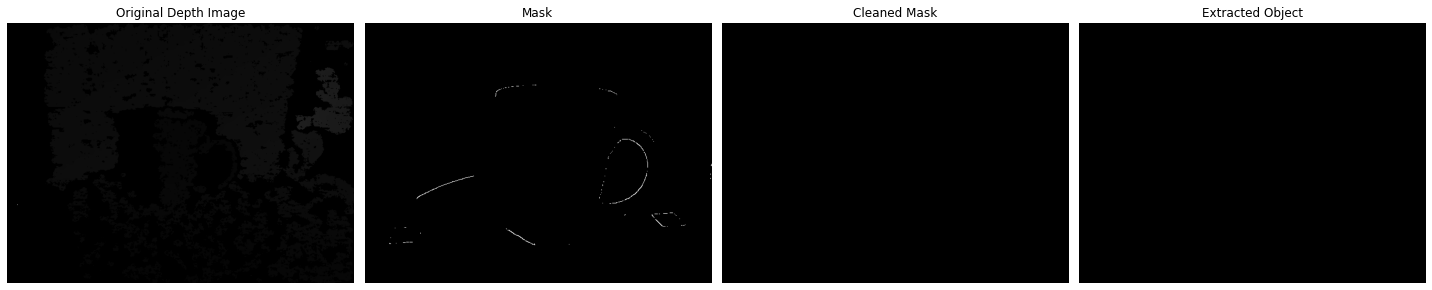

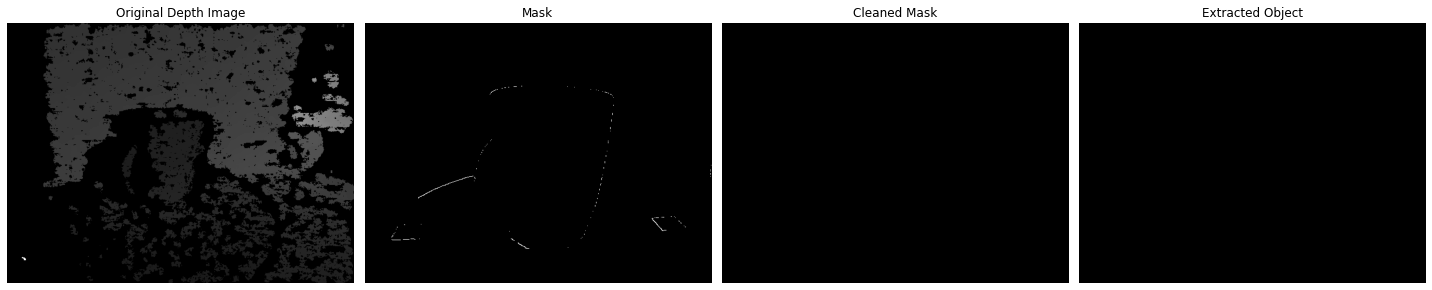

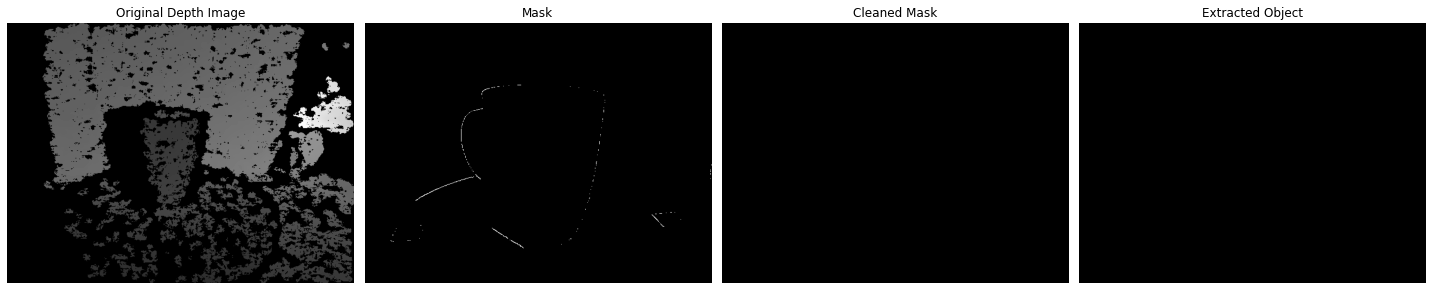

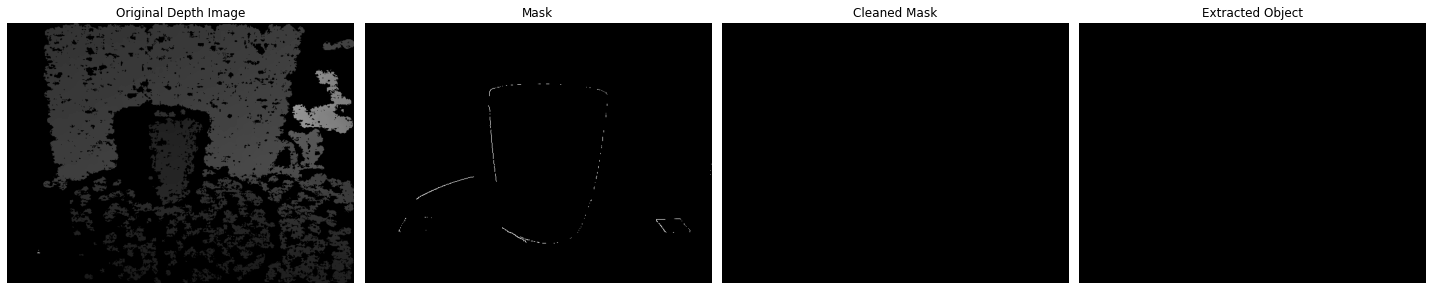

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def inpaint_depth_image(depth_image):
    # Create a mask where the depth values are zero (indicating gaps)
    mask = np.zeros(depth_image.shape, dtype=np.uint8)
    mask[depth_image == 0] = 255  # Assuming gaps are represented by zero depth

    # Create a bias mask towards the center of the image
    height, width = depth_image.shape
    center_x, center_y = width // 2, height // 2

    # Generate a distance transform for bias
    Y, X = np.ogrid[:height, :width]
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Normalize the distance to create a weight mask
    weight_mask = (distance_from_center / distance_from_center.max()) * 255
    weight_mask = weight_mask.astype(np.uint8)

    # Combine the original mask with the weight mask
    biased_mask = cv2.bitwise_and(mask, weight_mask)

    # Inpaint the depth image using the biased mask
    inpainted_depth = cv2.inpaint(depth_image, biased_mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    return inpainted_depth

# Function to apply mask and extract the object
def apply_mask(rgb_image, mask):
    mask_3channel = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    object_extracted = cv2.bitwise_and(rgb_image, mask_3channel)
    return object_extracted

# Function to reduce noise in an image using morphological operations
def reduce_noise(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)

    cleaned_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    kernel_close = np.ones((20,20), np.uint8)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_CLOSE, kernel_close)
    
    return cleaned_image

def remove_mask_boundary_objects(mask):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # Create an output mask to store the result
    output_mask = np.zeros_like(mask)

    # Iterate through each component
    for i in range(1, num_labels):
        # Check if the component touches the border
        if stats[i, cv2.CC_STAT_LEFT] == 0 or stats[i, cv2.CC_STAT_TOP] == 0 or \
        stats[i, cv2.CC_STAT_LEFT] + stats[i, cv2.CC_STAT_WIDTH] == mask.shape[1] or \
        stats[i, cv2.CC_STAT_TOP] + stats[i, cv2.CC_STAT_HEIGHT] == mask.shape[0]:
            continue
        # Otherwise, add the component to the output mask
        output_mask[labels == i] = 255
    
    return output_mask

# Function to create a mask by thresholding the green background and utilizing histogram
def create_mask_from_rgb(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Define the green color range
    lower_green = np.array([35, 20, 30])
    upper_green = np.array([86, 255, 255])

    # Create the mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    edges = cv2.Canny(rgb_image, 100, 200)  # Adjust thresholds as needed
    mask = cv2.bitwise_and(mask, mask, mask=edges)

    # Invert mask if necessary
    # final_mask = cv2.bitwise_not(mask)
    
    return mask

# Load images (assuming they are already loaded in rgb_images and depth_images lists)
for i in range(len(rgb_images)):
    mask = create_mask_from_rgb(rgb_images[i])
        
    mask_cleaned = remove_mask_boundary_objects(reduce_noise(mask, kernel_size=(9, 9))) # TODO add option for denoiser strength

    # depth_cleaned = inpaint_depth_image(depth_images[i])

    object_extracted = apply_mask(rgb_images[i], mask_cleaned)
    
    display_images([depth_images[i], mask, mask_cleaned, object_extracted],
                   ["Original Depth Image", "Mask", "Cleaned Mask", "Extracted Object"], cmap='gray')
